In [138]:
import pandas as pd
import matplotlib
# matplotlib.use('Agg')
import seaborn as sns
import json
import numpy as np
import pickle
from scipy.signal import find_peaks
import pandas as pd
import json
import numpy as np
import os
import shutil
from PIL import Image
import argparse
import scipy.misc
import imageio
from scipy import signal
from scipy.signal import find_peaks
import math
from numpy.fft import rfft, fft
from tqdm import tqdm
from scipy.interpolate import CubicSpline
from transforms3d.axangles import axangle2mat
import matplotlib.pyplot as plt
import seaborn as sns
import time
# pd.set_option('display.unicode.ambiguous_as_wide', True)
# pd.set_option('display.unicode.east_asian_width', True)

# Data Preprocessing

In [120]:
data_dir = './pd_data'
# read gait, survey and voice data
pd_gait_path = os.path.join(data_dir, 'pd_gait.csv')
pd_survey_path = os.path.join(data_dir, 'pd_survey.csv')
pd_voice_path = os.path.join(data_dir, 'pd_voice.csv')

if not os.path.exists(pd_gait_path):
    print("pd gait file is not exist")
if not os.path.exists(pd_survey_path):
    print("pd survey file is not exist")
if not os.path.exists(pd_voice_path):
    print("pd voice file is not exist")

In [121]:
pd_gait_df = pd.read_csv(pd_gait_path, index_col=0)
pd_gait_df.head()

,health-history,healthCode,professional-diagnosis,medication-start-year,onset-year,recordId,createdOn,appVersion,phoneInfo,accel_walking_outbound.json.items,deviceMotion_walking_outbound.json.items,pedometer_walking_outbound.json.items,accel_walking_return.json.items,deviceMotion_walking_return.json.items,pedometer_walking_return.json.items,accel_walking_rest.json.items,deviceMotion_walking_rest.json.items,medTimepoint
0,0,2257e233-5815-4211-b0f2-7f135d1604b0,True,2008.0,2007.0,0386fe7d-40d2-4f8a-993e-cfd1cdea587d,1.425929e+12,"version 1.0, build 7",iPhone 6,data/accel_walking_outbound.json.items-f855557...,data/deviceMotion_walking_outbound.json.items-...,data/pedometer_walking_outbound.json.items-41b...,data/accel_walking_return.json.items-857a2a93-...,data/deviceMotion_walking_return.json.items-da...,data/pedometer_walking_return.json.items-a03a2...,data/accel_walking_rest.json.items-8623afd5-5c...,data/deviceMotion_walking_rest.json.items-ff1f...,Another time
1,0,2257e233-5815-4211-b0f2-7f135d1604b0,True,2008.0,2007.0,9b7d730b-e9b5-45c2-9865-369130c146f4,1.426000e+12,"version 1.0, build 7",iPhone 6,data/accel_walking_outbound.json.items-43507cb...,data/deviceMotion_walking_outbound.json.items-...,data/pedometer_walking_outbound.json.items-8ea...,data/accel_walking_return.json.items-2519f0fb-...,data/deviceMotion_walking_return.json.items-27...,data/pedometer_walking_return.json.items-a7664...,data/accel_walking_rest.json.items-7b2715ab-30...,data/deviceMotion_walking_rest.json.items-eb2c...,Another time
2,0,2257e233-5815-4211-b0f2-7f135d1604b0,True,2008.0,2007.0,785a841c-2d4c-4379-aad5-959ca6a89d33,1.426000e+12,"version 1.0, build 7",iPhone 6,data/accel_walking_outbound.json.items-da1eb5f...,data/deviceMotion_walking_outbound.json.items-...,data/pedometer_walking_outbound.json.items-d4e...,data/accel_walking_return.json.items-d8106373-...,data/deviceMotion_walking_return.json.items-e9...,data/pedometer_walking_return.json.items-4143f...,data/accel_walking_rest.json.items-5ef22f64-24...,data/deviceMotion_walking_rest.json.items-9f32...,Another time
3,0,2257e233-5815-4211-b0f2-7f135d1604b0,True,2008.0,2007.0,fcd763ce-c8fe-444d-b538-0516ff430427,1.426000e+12,"version 1.0, build 7",iPhone 6,data/accel_walking_outbound.json.items-8506e92...,data/deviceMotion_walking_outbound.json.items-...,data/pedometer_walking_outbound.json.items-c38...,data/accel_walking_return.json.items-d0264f4e-...,data/deviceMotion_walking_return.json.items-da...,data/pedometer_walking_return.json.items-71bcb...,data/accel_walking_rest.json.items-b01af1d2-30...,data/deviceMotion_walking_rest.json.items-5fec...,Another time
4,0,2257e233-5815-4211-b0f2-7f135d1604b0,True,2008.0,2007.0,83235d50-3640-43f9-8329-0f37e05045bc,1.426098e+12,"version 1.0, build 7",iPhone 6,data/accel_walking_outbound.json.items-acb09a1...,data/deviceMotion_walking_outbound.json.items-...,data/pedometer_walking_outbound.json.items-766...,data/accel_walking_return.json.items-ea466043-...,data/deviceMotion_walking_return.json.items-49...,data/pedometer_walking_return.json.items-c3993...,data/accel_walking_rest.json.items-2855a976-fb...,data/deviceMotion_walking_rest.json.items-d68d...,Another time


In [122]:
check = {
    "Immediately before Parkinson medication", 
    "Just after Parkinson medication (at your best)"
}

normal_data = pd_gait_df[pd_gait_df['medTimepoint'].isin(check)]
normal_data.nunique() # healthCode -> 470

health-history                                237
healthCode                                    470
professional-diagnosis                          1
medication-start-year                          23
onset-year                                     25
recordId                                    10909
createdOn                                   10903
appVersion                                      3
phoneInfo                                       7
accel_walking_outbound.json.items           10907
deviceMotion_walking_outbound.json.items    10908
pedometer_walking_outbound.json.items       10643
accel_walking_return.json.items              6673
deviceMotion_walking_return.json.items       6673
pedometer_walking_return.json.items          6670
accel_walking_rest.json.items               10907
deviceMotion_walking_rest.json.items        10908
medTimepoint                                    2
dtype: int64

In [123]:
# healthCode list
healthCode_list = normal_data['healthCode'].unique()

In [124]:
# Selected hc
sel_k = 10
selected_hc = healthCode_list[:sel_k]
selected_df = normal_data[normal_data['healthCode'].isin(selected_hc)]
selected_df.nunique()

health-history                               10
healthCode                                   10
professional-diagnosis                        1
medication-start-year                         5
onset-year                                    6
recordId                                    415
createdOn                                   415
appVersion                                    3
phoneInfo                                     3
accel_walking_outbound.json.items           415
deviceMotion_walking_outbound.json.items    415
pedometer_walking_outbound.json.items       415
accel_walking_return.json.items             313
deviceMotion_walking_return.json.items      313
pedometer_walking_return.json.items         313
accel_walking_rest.json.items               415
deviceMotion_walking_rest.json.items        415
medTimepoint                                  2
dtype: int64

# Visualize Cos Distance Model

In [125]:
import torch
import numpy as np
from PIL import Image
import os
import sys
import pickle
import cv2
#!{sys.executable} -m pip install opencv-python

from torch.utils.data.dataloader import DataLoader
from torch.utils.data.dataset import Dataset
import torchvision.models as models
import torch.nn as nn

from scipy.spatial.distance import pdist, squareform
from scipy.stats import norm

In [126]:
def extract_features(model, dataloader, num_features, device, verbose = False):
    """
    Extract features.

    Args
        model(torch.nn.Module): CNN model.
        dataloader(torch.evaluate.data.DataLoader): Data loader.
        num_features(int): Number of features.
        device(torch.device): Using GPU or CPU.
        verbose(bool): Print log.

    Returns
        features(torch.Tensor): Features.
    """
    model.eval()
    model.set_extract_features(True)
    features = torch.zeros(len(dataloader.dataset.data), num_features)
    with torch.no_grad():
        N = len(dataloader)
        for i, (data, index) in enumerate(dataloader):
            if verbose:
                logger.debug('[Batch:{}/{}]'.format(i+1, N))
            data = data.to(device)
            features[index, :] = model(data).cpu()

    model.set_extract_features(False)
    model.train()

    return features

In [127]:
def generate_similarity_matrix(features, alpha = 2, beta = 2):
    """
    Generate similarity matrix.

    Args
        features(torch.Tensor): Features.
        alpha, beta(float): Hyper-parameters.

    Returns
        S(torch.Tensor): Similarity matrix.
    """
    # Cosine similarity
    cos_dist = squareform(pdist(features.numpy(), 'cosine'))
    # Find maximum count of cosine distance
    max_cnt, max_cos = 0, 0
    interval = 1. / 100
    cur = 0
    for i in range(100):
        cur_cnt = np.sum((cos_dist > cur) & (cos_dist < cur + interval))
        if max_cnt < cur_cnt:
            max_cnt = cur_cnt
            max_cos = cur
        cur += interval

    # Split features into two parts
    flat_cos_dist = cos_dist.reshape((-1, 1))
    left = flat_cos_dist[np.where(flat_cos_dist <= max_cos)[0]]
    right = flat_cos_dist[np.where(flat_cos_dist > max_cos)[0]]

    # Reconstruct gaussian distribution
    left = np.concatenate([left, 2 * max_cos - left])
    right = np.concatenate([2 * max_cos - right, right])

    # Model data using gaussian distribution
    left_mean, left_std = norm.fit(left)
    right_mean, right_std = norm.fit(right)

    # Construct similarity matrix
    S = (cos_dist < (left_mean - alpha * left_std)) * 1.0 + (cos_dist > (right_mean + beta * right_std)) * -1.0

    return torch.FloatTensor(S), cos_dist

In [128]:
def load_model(arch, code_length):
    """
    Load CNN model.

    Args
        arch(str): Model name.
        code_length(int): Hash code length.

    Returns
        model(torch.nn.Module): CNN model.
    """
    if arch == 'alexnet':
        model = models.alexnet(pretrained=True)
        model.classifier = model.classifier[:-2]
        model = ModelWrapper(model, 4096, code_length)
    elif arch == 'vgg16':
        model = models.vgg16(pretrained=True)
        model.classifier = model.classifier[:-3]
        model = ModelWrapper(model, 4096, code_length)
    else:
        raise ValueError("Invalid model name!")

    return model

class ModelWrapper(nn.Module):
    """
    Add tanh activate function into model.

    Args
        model(torch.nn.Module): CNN model.
        last_node(int): Last layer outputs size.
        code_length(int): Hash code length.
    """
    def __init__(self, model, last_node, code_length):
        super(ModelWrapper, self).__init__()
        self.model = model
        self.code_length = code_length
        self.hash_layer = nn.Sequential(
            nn.ReLU(inplace=True),
            nn.Linear(last_node, code_length),
            nn.Tanh(),
        )

        # Extract features
        self.extract_features = False

    def forward(self, x):
        if self.extract_features:
            return self.model(x)
        else:
            return self.hash_layer(self.model(x))

    def set_extract_features(self, flag):
        """
        Extract features.

        Args
            flag(bool): true, if one needs extract features.
        """
        self.extract_features = flag

    def snapshot(self, it, optimizer):
        """
        Save model snapshot.

        Args
            it(int): Iteration.
            optimizer(torch.optim): Optimizer.

        Returns
            None
        """
        torch.save({
            'iteration': it,
            'model_state_dict': self.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
        }, os.path.join('checkpoints', 'resume_{}.t'.format(it)))

    def load_snapshot(self, root, optimizer=None):
        """
        Load model snapshot.

        Args
            root(str): Path of model snapshot.
            optimizer(torch.optim): Optimizer.

        Returns
            optimizer(torch.optim, optional): Optimizer, if parameter 'optimizer' given.
            it(int): Iteration, if parameter 'optimizer' given.
        """
        checkpoint = torch.load(root)
        self.load_state_dict(checkpoint['model_state_dict'])
        if optimizer:
            optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
            it = checkpoint['iteration']
            return optimizer, it

In [129]:
num_features = {
    'alexnet': 4096,
    'vgg16': 4096,
}
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
code_length = 12
arch = 'vgg16'

model = load_model(arch, code_length)
model.to(device)

ModelWrapper(
  (model): VGG(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace=True)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace=True)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace=True)
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (15): ReLU(inplace=True)
      (

In [130]:
class pdData(Dataset):
    """
    pdData dataset.
    """

    def __init__(self, record_set=None):
        
        self.base_folder = './result/feature_seg'
        self.data = []
        
        for file_name in os.listdir(self.base_folder):
            fn = file_name.split('_')
            if fn[0] not in record_set:
                continue
                
            file_path = os.path.join(self.base_folder, file_name)
            try:
                img = cv2.imread(file_path)
                self.data.append(img)
            except:
                print("image path not exist")
         
        img_size = self.data[0].shape
        self.data = np.vstack(self.data).reshape(-1, img_size[-3],img_size[-2], img_size[-1])
        self.data = torch.from_numpy(self.data.transpose((0,3,1,2))).type(torch.FloatTensor)
        
    def __getitem__(self, index):
        
        img = self.data[index]
        #img = Image.fromarray(img)
        return img, index

    def __len__(self):
        return len(self.data)

/opt/conda/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

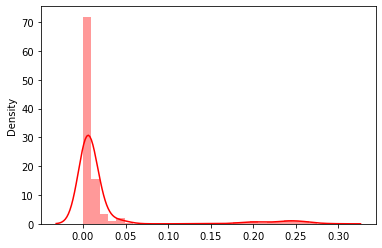

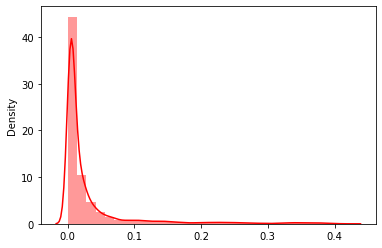

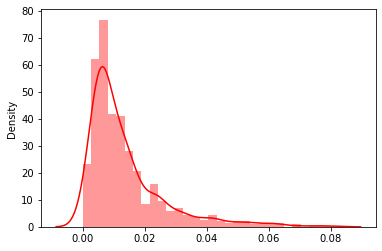

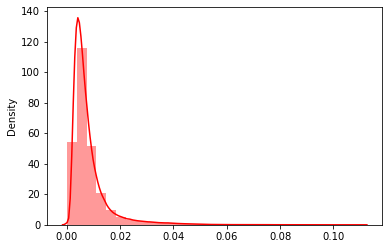

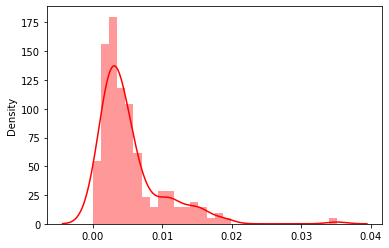

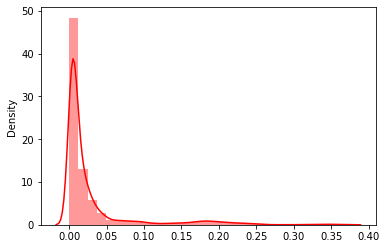

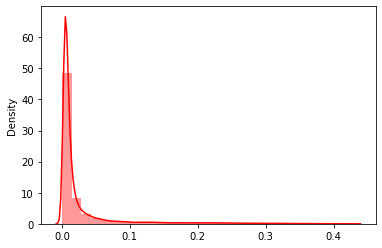

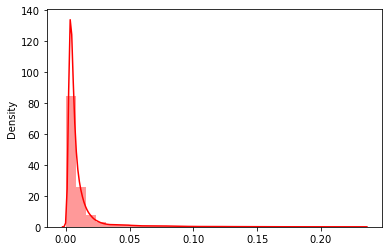

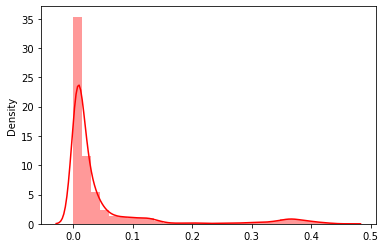

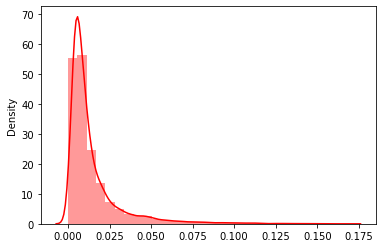

In [147]:
for idx, hc_idx in enumerate(selected_hc):
    selected_record_id = normal_data[normal_data['healthCode'] == hc_idx]['recordId']
    pd_dataset = pdData(set(selected_record_id))
    
    pd_dataloader = DataLoader(
            pd_dataset,
            batch_size=24,
            pin_memory=True,
            num_workers=0,
    )
    
    features = extract_features(model, pd_dataloader, num_features[arch], device)
    S, cos_dist = generate_similarity_matrix(features)
    
    
    cos_dist = cos_dist.reshape(-1)
    fig = plt.figure()
    #ax = fig.add_subplot()
    #ax.hist(cos_dist, bins=50, color='blue', alpha=0.7)
    sns.set_palette("hls")
    sns.distplot(cos_dist,color="r",bins=30,kde=True)
    savepath = "./subject_plot/h" + str(idx)
    plt.savefig(savepath)